In [182]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import random
import os
import sys
os.environ["PATH"] += ":/usr/local/nvidia/bin:/usr/local/cuda/bin"

plt.style.use('dark_background')

In [2]:
directory = "./images"

height = 64
width = 64
batch_size = 128
channels = 3

transform = transforms.Compose([transforms.Resize((height, width)), transforms.ToTensor()])
x_train = ImageFolder(directory, transform = transform)
dataloader = torch.utils.data.DataLoader(x_train, batch_size = batch_size, shuffle = True)

In [3]:
seed_size = 500
emb_size = 50

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(seed_size + emb_size, 1024 * 16)
        self.unflatten = nn.Unflatten(1, (1024, 4, 4))
        self.conv1 = nn.ConvTranspose2d(1024, 512, 4, padding = 1, stride = 2)
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, padding = 1, stride = 2)
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, padding = 1, stride = 2)
        self.conv4 = nn.ConvTranspose2d(128, channels, 4, padding = 1, stride = 2)
        self.embed = nn.Embedding(43, emb_size)

    def forward(self, x, labels):
        emb = self.embed(labels)
        out = self.lin1(torch.cat([x, emb], dim = 1))
        out = self.unflatten(out)
        out = torch.relu(self.conv1(out))
        out = torch.relu(self.conv2(out))
        out = torch.relu(self.conv3(out))
        out = self.conv4(out)
        return torch.sigmoid(out)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(channels + 1, 128, 4, padding = 1, stride = 2)
        self.conv2 = nn.Conv2d(128, 256, 4, padding = 1, stride = 2)
        self.conv3 = nn.Conv2d(256, 512, 4, padding = 1, stride = 2)
        self.conv4 = nn.Conv2d(512, 1024, 4, padding = 1, stride = 2)
        self.leaky = nn.LeakyReLU(0.2)
        self.flatten = nn.Flatten()
        self.output = nn.Linear(1024 * 16, 1)
        self.embed = nn.Embedding(43, height * width)

    def forward(self, x, labels):
        emb = self.embed(labels).view(labels.shape[0], 1, height, width)
        out = torch.cat([x, emb], dim = 1)
        out = self.leaky(self.conv1(out))
        out = self.leaky(self.conv2(out))
        out = self.leaky(self.conv3(out))
        out = self.leaky(self.conv4(out))
        out = self.flatten(out)
        out = self.output(out)
        out = torch.sigmoid(out)
        return out

torch.Size([1, 3, 64, 64])


tensor([[0.4954]], grad_fn=<SigmoidBackward0>)

In [4]:
class GAN:
    def __init__(self):
        super().__init__()
        self.generator = Generator()
        self.discriminator = Discriminator()
        self.loss = torch.nn.BCELoss()
        self.generator_optimizer = torch.optim.Adam(self.generator.parameters(),
                                                    lr = 0.0002, betas = (0.5, 0.999))
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(),
                                                        lr = 0.0002, betas = (0.5, 0.999))
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.generator.to(self.device)
        self.discriminator.to(self.device)

    def fit(self, x_train, epochs = 3):
        for epoch in range(epochs):
            disc_loss = 0.0
            gen_loss = 0.0
            for i, (x, y) in enumerate(x_train, 0):
                x = x.to(self.device)
                y = y.to(self.device)
                fake_images = self.generator(torch.randn(x.shape[0], seed_size).to(self.device), y)
                self.discriminator_optimizer.zero_grad()

                pred_real = self.discriminator(x, y)
                pred_fake = self.discriminator(fake_images, y)
                pred = torch.cat([pred_real, pred_fake]).view(-1).to(self.device)

                y_train_real = torch.zeros_like(pred_real, requires_grad = True)
                y_train_fake = torch.ones_like(pred_fake, requires_grad = True)
                y_train = torch.cat([y_train_real, y_train_fake]).view(-1)


                discriminator_loss = self.loss(pred, y_train)
                disc_loss += discriminator_loss.item()
                discriminator_loss.backward()
                self.discriminator_optimizer.step()


                # Generator
                self.generator_optimizer.zero_grad()
                fake_images = self.generator(torch.randn(x.shape[0], seed_size).to(self.device), y)
                pred = self.discriminator(fake_images, y).view(-1)
                generator_loss = self.loss(pred, y_train_real.view(-1))
                gen_loss += generator_loss.item()
                generator_loss.backward()
                self.generator_optimizer.step()
                sys.stdout.write("\rEpoch {} batch {}/{}. Discriminator loss: {:0.4f}. Generator loss: {:5.4f}"
                                 .format(epoch + 1, i + 1, len(x_train), disc_loss / (i + 1), gen_loss / (i + 1)))
                sys.stdout.flush()

            print()

    def gen_image(self, labels):
        lab = torch.IntTensor(labels).to(self.device)
        return torch.moveaxis(self.generator(torch.randn(len(labels), seed_size).to(self.device), lab),
                              [1, 2, 3], [3, 1, 2]).detach().cpu()

gan = GAN()

In [5]:
gan.fit(dataloader, epochs = 50)

Epoch 1 batch 307/307. Discriminator loss: 0.6072. Generator loss: 1.1077
Epoch 2 batch 307/307. Discriminator loss: 0.5687. Generator loss: 1.4093
Epoch 3 batch 307/307. Discriminator loss: 0.5278. Generator loss: 1.6280
Epoch 4 batch 307/307. Discriminator loss: 0.5002. Generator loss: 1.7243
Epoch 5 batch 307/307. Discriminator loss: 0.4882. Generator loss: 1.7830
Epoch 6 batch 307/307. Discriminator loss: 0.4918. Generator loss: 1.8033
Epoch 7 batch 307/307. Discriminator loss: 0.4883. Generator loss: 1.8306
Epoch 8 batch 307/307. Discriminator loss: 0.4910. Generator loss: 1.7919
Epoch 9 batch 307/307. Discriminator loss: 0.4935. Generator loss: 1.8027
Epoch 10 batch 307/307. Discriminator loss: 0.4880. Generator loss: 1.8038
Epoch 11 batch 307/307. Discriminator loss: 0.4940. Generator loss: 1.7701
Epoch 12 batch 307/307. Discriminator loss: 0.4945. Generator loss: 1.7272
Epoch 13 batch 307/307. Discriminator loss: 0.4967. Generator loss: 1.7375
Epoch 14 batch 307/307. Discrimina

In [98]:
torch.save(gan.discriminator, 'discriminator')
torch.save(gan.generator, 'generator')

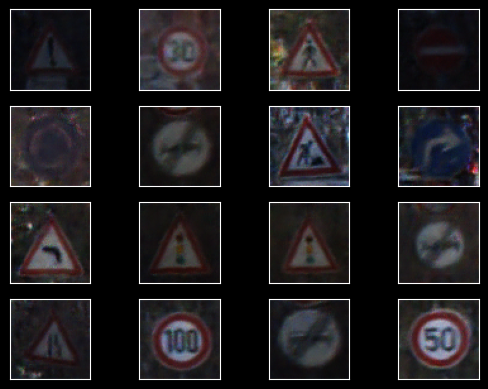

In [186]:
labels = []
rows, cols = 4, 4
for _ in range(rows * cols):
    labels.append(random.randint(0, 42))

generated = gan.gen_image(labels)
fig, ax = plt.subplots(rows, cols)
for i in range(rows):
    for j in range(cols):
        ax[i][j].get_xaxis().set_visible(False)
        ax[i][j].get_yaxis().set_visible(False)
        ax[i][j].imshow(generated[i * rows + j])